<h1>Revisiting the ML model to refine the feature set to make the output more meaningful</h1>
<p>This notebook looks at factors influencing goalie performance (save percentage) and the injury (via t_tests) implementing them in a random forest ml model</p>

In [96]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import stats
import sqlite3
from joblib import dump, load
pd.set_option('display.max_rows', 500)

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [97]:
DB = "../assests/hockey_data_goalies.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

<h2>Get the training Data</h2>

In [98]:
#import data
goalie_data =pd.read_csv('advancedgoaliestats_withadditionalgoalies.csv')
goalie_data.drop(columns=['Unnamed: 0'],inplace=True)
goalie_data

,player_id,team_id,opp_id,date_game,age,rest_days,min_season,shots_against,save_pct,min3W,sa3W,svepct3W,future_save_pct,pre_inj,injured
0,aebisda01,COL,CHI,2000-10-26,22.718,8,60.000000,21,0.952,60.000000,21,0.952381,1.000,0,0
1,aebisda01,COL,CAR,2000-11-03,22.740,8,120.000000,39,0.974,120.000000,39,0.974359,0.885,0,0
2,aebisda01,COL,MDA,2000-11-11,22.762,8,180.000000,65,0.938,120.000000,44,0.931818,0.947,0,0
3,aebisda01,COL,PHX,2000-11-16,22.775,5,240.000000,84,0.940,120.000000,45,0.911111,0.786,0,0
4,aebisda01,COL,NJD,2000-12-05,22.827,19,299.916667,112,0.902,59.916667,28,0.785714,0.818,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68154,zatkoje01,LAK,DAL,2016-12-23,29.540,8,341.316667,145,0.890,124.266667,39,0.871795,0.903,1,0
68155,zatkoje01,LAK,DET,2017-01-05,29.575,13,402.433333,176,0.892,61.116667,31,0.903226,0.818,1,0
68156,zatkoje01,LAK,DAL,2017-01-09,29.586,4,462.433333,198,0.884,121.116667,53,0.867925,1.000,1,0
68157,zatkoje01,LAK,NYR,2017-01-23,29.625,14,471.200000,201,0.886,68.766667,25,0.840000,0.824,1,0


In [33]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate as CV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from joblib import dump, load

<h2>Now Fit</h2>

In [91]:
b = 1 #balance factor
data = goalie_data[goalie_data['injured']==0].iloc[np.random.randint(0,50000,goalie_data[goalie_data['injured']==1].shape[0]*b),:]
data = data.append(goalie_data[goalie_data['injured']==1])
mask = (np.random.rand(data.shape[0]) < 0.8)
train = data[mask].sample(frac=1)
test = data[~mask].sample(frac=1)

#create pipeline for standard scaling
num_pipeline = Pipeline([('std_scaler',StandardScaler())])
#select columns to fit
#columns = ['age','min_season','rest_days','shots_against','save_pct','min3W','sa3W','svepct3W','pre_inj']
columns = ['age','min_season','rest_days','shots_against','min3W','sa3W','pre_inj']
#columns = ['age','min_season','rest_days','pre_inj']

#get training data
trainX = num_pipeline.fit_transform(train[columns])
trainY = np.array(train['injured'])
testX = num_pipeline.fit_transform(test[columns])
testY = np.array(test['injured'])
ran_for = RandomForestClassifier()
ran_for.fit(trainX,trainY)

#run on training data
predicted = ran_for.predict(trainX)
true_positives = np.sum((predicted==1)&(trainY==1))
false_positives = np.sum((predicted==1)&(trainY==0))
true_negatives = np.sum((predicted==0)&(trainY==0))
false_negatives = np.sum((predicted==0)&(trainY==1))

print("Precision is %0.2f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.2f" % (true_positives/(true_positives+false_negatives)))
confusion_matrix(predicted,trainY)

Precision is 1.00
Recall is 1.00


array([[722,   0],
       [  0, 708]], dtype=int64)

In [92]:
#try on test data

predicted = ran_for.predict(testX)
true_positives = np.sum((predicted==1)&(testY==1))
false_positives = np.sum((predicted==1)&(testY==0))
true_negatives = np.sum((predicted==0)&(testY==0))
false_negatives = np.sum((predicted==0)&(testY==1))

print("Precision is %0.2f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.2f" % (true_positives/(true_positives+false_negatives)))
confusion_matrix(predicted,testY)

Precision is 0.68
Recall is 0.66


array([[102,  57],
       [ 52, 111]], dtype=int64)

<h2>Try on all the data</h2>

In [93]:
gd = goalie_data.sample(frac=1)
predicted = ran_for.predict(num_pipeline.fit_transform(gd[columns]))
gdY = np.array(gd['injured'])
true_positives = np.sum((predicted==1)&(gdY==1))
false_positives = np.sum((predicted==1)&(gdY==0))
true_negatives = np.sum((predicted==0)&(gdY==0))
false_negatives = np.sum((predicted==0)&(gdY==1))
print(false_positives)
print("Precision is %0.2f" % (true_positives/(true_positives+false_positives)))
print("Recall is %0.2f" % (true_positives/(true_positives+false_negatives)))

print('true_positives',true_positives,tp)
print('false_positive',false_positives,fp)
print('false_negative',false_negatives,fn)
print('true_negative',true_negatives,tn)

33912
Precision is 0.02
Recall is 0.89
true_positives 777 61
false_positive 33912 460
false_negative 99 832
true_negative 33371 30222


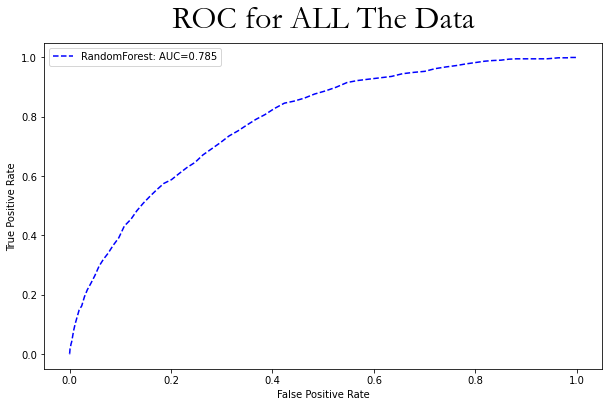

In [94]:
fpr,tpr,thresholds = roc_curve(np.array(gd['injured']),
                               ran_for.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1])
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,"b--",label="RandomForest: AUC=%0.3f"%(roc_auc_score(np.array(gd['injured']),ran_for.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1])))
#plt.plot(thresholds,recall[:-1],"g-",label="recall")
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for ALL The Data',font='Garamond',fontsize=32,pad = 15)
plt.savefig('ROCforAlltheData.png')
plt.show()

In [95]:
ypred = ran_for.predict_proba(num_pipeline.fit_transform(gd[columns]))[:,1]
yreal = np.array(gd['injured'])
for m in np.arange(0,1,.1):
    tp = ((ypred>=m)&(yreal==1)).sum()
    fp = ((ypred>=m)&(yreal==0)).sum()
    fn = ((ypred<=m)&(yreal==1)).sum()

    print("Trial %0.1f:Identified %s of %s, Precision of %0.2f and Recall of %0.2f.  TP:%d,FP:%d"%(m,tp,yreal.sum(),tp/(tp+fp),tp/(tp+fn),tp,fp))

Trial 0.0:Identified 876 of 876, Precision of 0.01 and Recall of 1.00.  TP:876,FP:67283
Trial 0.1:Identified 876 of 876, Precision of 0.01 and Recall of 1.00.  TP:876,FP:67223
Trial 0.2:Identified 875 of 876, Precision of 0.01 and Recall of 1.00.  TP:875,FP:66168
Trial 0.3:Identified 872 of 876, Precision of 0.01 and Recall of 1.00.  TP:872,FP:60233
Trial 0.4:Identified 848 of 876, Precision of 0.02 and Recall of 0.96.  TP:848,FP:49917
Trial 0.5:Identified 788 of 876, Precision of 0.02 and Recall of 0.89.  TP:788,FP:35348
Trial 0.6:Identified 644 of 876, Precision of 0.03 and Recall of 0.74.  TP:644,FP:21145
Trial 0.7:Identified 466 of 876, Precision of 0.04 and Recall of 0.53.  TP:466,FP:10673
Trial 0.8:Identified 259 of 876, Precision of 0.06 and Recall of 0.29.  TP:259,FP:3905
Trial 0.9:Identified 52 of 876, Precision of 0.11 and Recall of 0.06.  TP:52,FP:406
